In [ ]:
# Download the dataset
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

# Uncompress the dataset
!tar -xzf /content/maps.tar.gz

--2023-01-09 15:34:45--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  1004KB/s    in 3m 34s  

2023-01-09 15:38:19 (1.12 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
# Import dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CallbackList

from gan_model import define_gan

In [ ]:
# Set up paths
TRAIN_IMAGES_DIRPATH = "/content/data/maps/train"
CHECKPOINT_FILEPATH = "/content/generator_checkpoint/checkpoint.ckpt"

## Load the Dataset

In [ ]:
# Get file paths of train images
train_fpaths = []
for fname in os.listdir(TRAIN_IMAGES_DIRPATH):
    train_fpaths.append(os.path.join(TRAIN_IMAGES_DIRPATH, fname))

In [ ]:
def load_images(fpaths, img_size=(256, 512)):
    src_imgs, tar_imgs = [], []
    
    for fpath in fpaths:
        img = load_img(path=fpath, target_size=img_size)
        img_arr = img_to_array(img) # img_arr.dtype == 'float32'
        src, tar = img_arr[:, :256, :], img_arr[:, 256:, :] # Segment input image into source and target images
        src_imgs.append(src)
        tar_imgs.append(tar)

    return (np.asarray(src_imgs), np.asarray(tar_imgs))

In [ ]:
# Load train dataset
train_dataset = load_images(train_fpaths)
train_src_imgs, train_tar_imgs = train_dataset

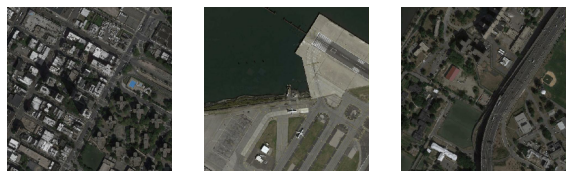

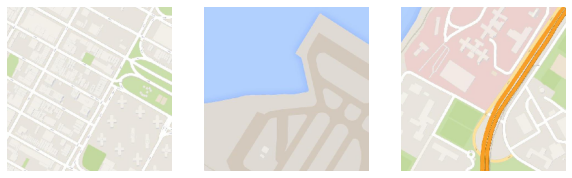

In [ ]:
# Plot random segmented train samples

rand_idxs = np.random.randint(0, train_src_imgs.shape[0], 3)

plt.figure(figsize=(10, 12))
for idx in range(3):
    plt.subplot(1, 3, idx+1)
    plt.imshow(train_src_imgs[rand_idxs[idx]].astype('uint8'))
    plt.axis(False)

plt.figure(figsize=(10, 12))
for idx in range(3):
    plt.subplot(1, 3, idx+1)
    plt.imshow(train_tar_imgs[rand_idxs[idx]].astype('uint8'))
    plt.axis(False)

plt.show()

## Preprocess the Dataset

In [ ]:
def preprocess_data(dataset):
    X1, X2 = dataset
    # Scale from [0, 255] to [-1, 1]
    X1 = (X1 / 127.5) - 1
    X2 = (X2 / 127.5) - 1

    return (X1, X2)

In [ ]:
# Get preprocessed train images
train_dataset = preprocess_data(train_dataset)

## Utilities for Generating Data

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # Get source and target images from the dataset
    src_imgs, tar_imgs = dataset

    # Select random instances from the dataset
    rand_idx = np.random.randint(0, src_imgs.shape[0], n_samples)
    X1, X2 = src_imgs[rand_idx], tar_imgs[rand_idx]

    # Create real class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))

    return [X1, X2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
    # Generate fake instances
    X = g_model.predict(samples, verbose=0)

    # Create fake class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

## Utility for Summarizing Performance

In [ ]:
def summarize_performance(epoch, g_model, dataset, n_samples=3):
    [X1_real, X2_real], _ = generate_real_samples(dataset, n_samples, 1)
    X2_fake, _ = generate_fake_samples(g_model, X1_real, 1)

    # Rescale the images
    X1_real = np.uint8((X1_real + 1) * 127.5)
    X2_real = np.uint8((X2_real + 1) * 127.5)
    X2_fake = np.uint8((X2_fake + 1) * 127.5)

    plt.figure(figsize=(12, 9))
    # Plot the images
    for i in range(n_samples):
        plt.subplot(n_samples, 3, 3*i+1)
        plt.imshow(X1_real[i])
        plt.title("Source Image")
        plt.axis(False)
    
    for i in range(n_samples):
        plt.subplot(n_samples, 3, 3*i+2)
        plt.imshow(X2_real[i])
        plt.title("Target Image")
        plt.axis(False)
    
    for i in range(n_samples):
        plt.subplot(n_samples, 3, 3*i+3)
        plt.imshow(X2_fake[i])
        plt.title("Generated Image")
        plt.axis(False)
    plt.show()

## Get the Generator, Discriminator and GAN Model

In [ ]:
g_model, d_model, gan_model = define_gan(inp_shape=train_src_imgs.shape[1:])

## Establish Checkpoint Callback

In [ ]:
chkpt_callback = ModelCheckpoint(filepath=CHECKPOINT_FILEPATH,
                                 monitor="g_loss",
                                 save_weights_only=True,
                                 save_best_only=True,
                                 mode="auto",
                                 save_freq="epoch",
                                 verbose=0)

callbacks = CallbackList([chkpt_callback], model=g_model)
logs = {}

## Train the Model

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=70, n_batch=1):
    src_imgs, tar_imgs = dataset
    batch_per_epoch = int(len(src_imgs) / n_batch)
    patch_shape = d_model.output_shape[1] # output patch shape of the discriminator

    callbacks.on_train_begin(logs=logs)
    
    # Loop through each epoch
    for epoch in range(n_epochs):

        callbacks.on_epoch_begin(epoch, logs=logs)

        # Loop through each batch
        for batch in range(batch_per_epoch):
            # Get a batch of real samples
            [src_img, tar_img_real], y_real = generate_real_samples(dataset, n_batch, patch_shape)
            # Get a batch of fake samples
            tar_img_fake, y_fake = generate_fake_samples(g_model, src_img, patch_shape)
            
            #----------------PHASE 1 : Train the discriminator----------------#
            # For real samples
            d_loss1 = d_model.train_on_batch(x=[src_img, tar_img_real], y=y_real)
            # For fake samples
            d_loss2 = d_model.train_on_batch(x=[src_img, tar_img_fake], y=y_fake)

            #----------------PHASE 2 : Train the generator--------------------#
            g_loss, d_loss, gan_loss = gan_model.train_on_batch(x=src_img, y=[y_real, tar_img_real])

            
        logs["g_loss"] = g_loss
        callbacks.on_epoch_end(epoch, logs=logs)

        # Summarise the performance 
        print(f"For epoch {epoch+1}/{n_epochs},")
        print(f"d_loss (for real images): {d_loss1:.4f}\t d_loss (for fake images): {d_loss2:.4f}\t g_loss: {g_loss:.4f}\n")

        if (epoch+1) % 10 == 0:
            summarize_performance(epoch+1, g_model, dataset, 3)

    callbacks.on_train_end(logs=logs)

For epoch 1/70,
d_loss (for real images): 0.5602	 d_loss (for fake images): 0.2110	 g_loss: 8.8855

For epoch 2/70,
d_loss (for real images): 0.1001	 d_loss (for fake images): 0.1320	 g_loss: 15.2453

For epoch 3/70,
d_loss (for real images): 0.0397	 d_loss (for fake images): 0.1597	 g_loss: 6.1235

For epoch 4/70,
d_loss (for real images): 0.0146	 d_loss (for fake images): 0.3951	 g_loss: 14.0467

For epoch 5/70,
d_loss (for real images): 0.2209	 d_loss (for fake images): 0.1160	 g_loss: 11.3927

For epoch 6/70,
d_loss (for real images): 0.0266	 d_loss (for fake images): 0.0851	 g_loss: 9.0764

For epoch 7/70,
d_loss (for real images): 0.0575	 d_loss (for fake images): 0.2408	 g_loss: 7.9342

For epoch 8/70,
d_loss (for real images): 0.0061	 d_loss (for fake images): 0.6130	 g_loss: 16.5143

For epoch 9/70,
d_loss (for real images): 0.0630	 d_loss (for fake images): 0.3091	 g_loss: 5.3122

For epoch 10/70,
d_loss (for real images): 0.2231	 d_loss (for fake images): 0.2161	 g_loss: 8.0

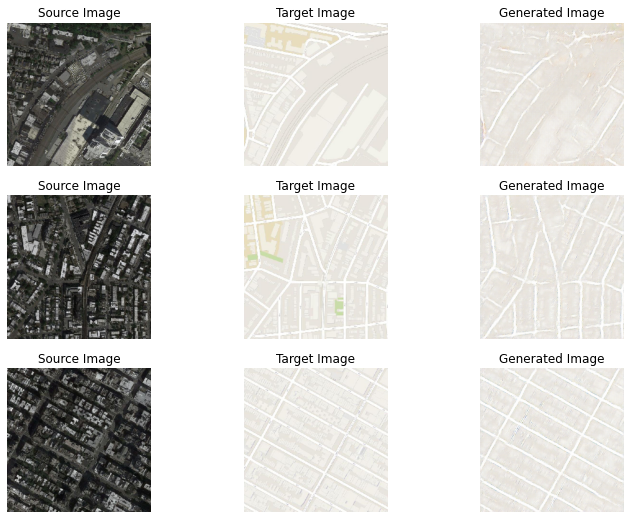

For epoch 11/70,
d_loss (for real images): 0.1780	 d_loss (for fake images): 0.1461	 g_loss: 11.8631

For epoch 12/70,
d_loss (for real images): 0.2702	 d_loss (for fake images): 0.2094	 g_loss: 6.9005

For epoch 13/70,
d_loss (for real images): 0.0916	 d_loss (for fake images): 0.1246	 g_loss: 14.9071

For epoch 14/70,
d_loss (for real images): 0.7091	 d_loss (for fake images): 0.2328	 g_loss: 5.7626

For epoch 15/70,
d_loss (for real images): 0.0600	 d_loss (for fake images): 0.1903	 g_loss: 11.4309

For epoch 16/70,
d_loss (for real images): 0.3536	 d_loss (for fake images): 0.3337	 g_loss: 6.4642

For epoch 17/70,
d_loss (for real images): 0.3423	 d_loss (for fake images): 0.3198	 g_loss: 5.8250

For epoch 18/70,
d_loss (for real images): 0.1340	 d_loss (for fake images): 0.3966	 g_loss: 7.6191

For epoch 19/70,
d_loss (for real images): 0.0824	 d_loss (for fake images): 0.2368	 g_loss: 6.3913

For epoch 20/70,
d_loss (for real images): 0.5242	 d_loss (for fake images): 0.3913	 g_l

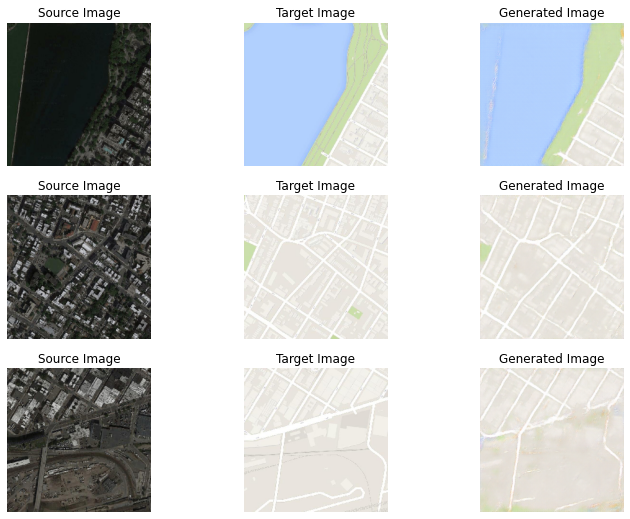

For epoch 21/70,
d_loss (for real images): 0.1865	 d_loss (for fake images): 0.3191	 g_loss: 6.4155

For epoch 22/70,
d_loss (for real images): 0.3964	 d_loss (for fake images): 0.3228	 g_loss: 6.4629

For epoch 23/70,
d_loss (for real images): 0.4244	 d_loss (for fake images): 0.2684	 g_loss: 4.9491

For epoch 24/70,
d_loss (for real images): 0.4427	 d_loss (for fake images): 0.3328	 g_loss: 4.0201

For epoch 25/70,
d_loss (for real images): 0.3404	 d_loss (for fake images): 0.3297	 g_loss: 5.8273

For epoch 26/70,
d_loss (for real images): 0.4654	 d_loss (for fake images): 0.2553	 g_loss: 5.3068

For epoch 27/70,
d_loss (for real images): 0.4158	 d_loss (for fake images): 0.2838	 g_loss: 4.8939

For epoch 28/70,
d_loss (for real images): 0.2630	 d_loss (for fake images): 0.3325	 g_loss: 4.9524

For epoch 29/70,
d_loss (for real images): 0.5027	 d_loss (for fake images): 0.2918	 g_loss: 4.1081

For epoch 30/70,
d_loss (for real images): 0.5126	 d_loss (for fake images): 0.2737	 g_loss

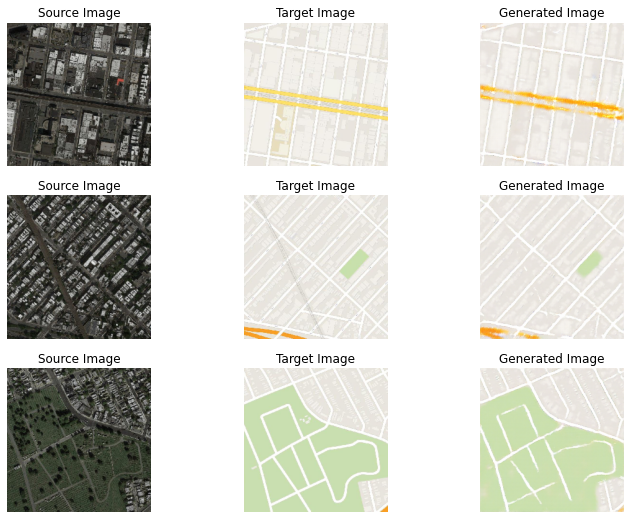

For epoch 31/70,
d_loss (for real images): 0.3366	 d_loss (for fake images): 0.3279	 g_loss: 5.0773

For epoch 32/70,
d_loss (for real images): 0.2545	 d_loss (for fake images): 0.3249	 g_loss: 5.1023

For epoch 33/70,
d_loss (for real images): 0.2531	 d_loss (for fake images): 0.2631	 g_loss: 5.0587

For epoch 34/70,
d_loss (for real images): 0.2966	 d_loss (for fake images): 0.2954	 g_loss: 5.3440

For epoch 35/70,
d_loss (for real images): 0.2230	 d_loss (for fake images): 0.4518	 g_loss: 2.3732

For epoch 36/70,
d_loss (for real images): 0.2524	 d_loss (for fake images): 0.4282	 g_loss: 5.6081

For epoch 37/70,
d_loss (for real images): 0.2980	 d_loss (for fake images): 0.2421	 g_loss: 4.3286

For epoch 38/70,
d_loss (for real images): 0.3209	 d_loss (for fake images): 0.3278	 g_loss: 5.3960

For epoch 39/70,
d_loss (for real images): 0.3024	 d_loss (for fake images): 0.3899	 g_loss: 4.0149

For epoch 40/70,
d_loss (for real images): 0.2997	 d_loss (for fake images): 0.3094	 g_loss

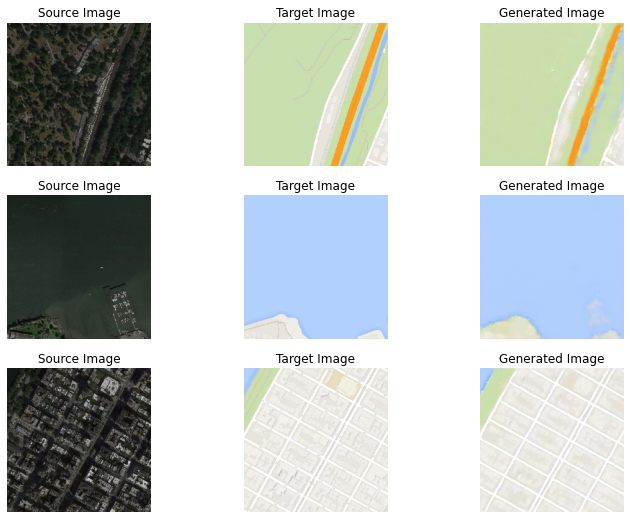

For epoch 41/70,
d_loss (for real images): 0.3516	 d_loss (for fake images): 0.2965	 g_loss: 4.6409

For epoch 42/70,
d_loss (for real images): 0.3138	 d_loss (for fake images): 0.2323	 g_loss: 3.9831

For epoch 43/70,
d_loss (for real images): 0.4004	 d_loss (for fake images): 0.2238	 g_loss: 3.6903

For epoch 44/70,
d_loss (for real images): 0.3874	 d_loss (for fake images): 0.3029	 g_loss: 4.6785

For epoch 45/70,
d_loss (for real images): 0.4508	 d_loss (for fake images): 0.2304	 g_loss: 4.9390

For epoch 46/70,
d_loss (for real images): 0.3701	 d_loss (for fake images): 0.3604	 g_loss: 3.6656

For epoch 47/70,
d_loss (for real images): 0.2832	 d_loss (for fake images): 0.3902	 g_loss: 1.8568

For epoch 48/70,
d_loss (for real images): 0.2464	 d_loss (for fake images): 0.3289	 g_loss: 5.0768

For epoch 49/70,
d_loss (for real images): 0.2876	 d_loss (for fake images): 0.2729	 g_loss: 5.1760

For epoch 50/70,
d_loss (for real images): 0.3342	 d_loss (for fake images): 0.3445	 g_loss

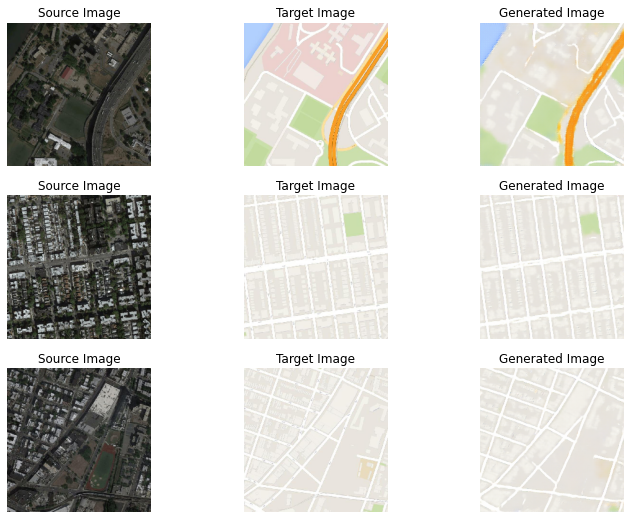

For epoch 51/70,
d_loss (for real images): 0.3210	 d_loss (for fake images): 0.2760	 g_loss: 4.3012

For epoch 52/70,
d_loss (for real images): 0.3400	 d_loss (for fake images): 0.3732	 g_loss: 3.6092

For epoch 53/70,
d_loss (for real images): 0.2936	 d_loss (for fake images): 0.3449	 g_loss: 4.6584

For epoch 54/70,
d_loss (for real images): 0.3025	 d_loss (for fake images): 0.3241	 g_loss: 4.5470

For epoch 55/70,
d_loss (for real images): 0.3125	 d_loss (for fake images): 0.3286	 g_loss: 3.6120

For epoch 56/70,
d_loss (for real images): 0.3354	 d_loss (for fake images): 0.5093	 g_loss: 1.9934

For epoch 57/70,
d_loss (for real images): 0.3115	 d_loss (for fake images): 0.2935	 g_loss: 4.5090

For epoch 58/70,
d_loss (for real images): 0.3466	 d_loss (for fake images): 0.4421	 g_loss: 2.0510

For epoch 59/70,
d_loss (for real images): 0.2040	 d_loss (for fake images): 0.3045	 g_loss: 5.7872

For epoch 60/70,
d_loss (for real images): 0.5061	 d_loss (for fake images): 0.2708	 g_loss

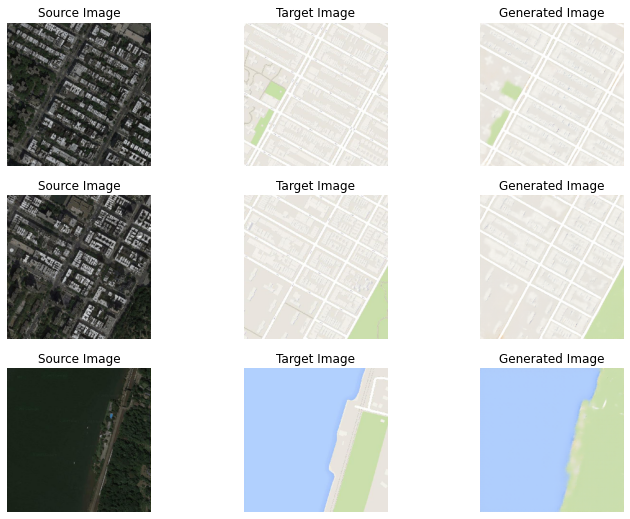

For epoch 61/70,
d_loss (for real images): 0.3094	 d_loss (for fake images): 0.4443	 g_loss: 1.7328

For epoch 62/70,
d_loss (for real images): 0.2495	 d_loss (for fake images): 0.3526	 g_loss: 4.3074

For epoch 63/70,
d_loss (for real images): 0.2302	 d_loss (for fake images): 0.3320	 g_loss: 4.9697

For epoch 64/70,
d_loss (for real images): 0.2383	 d_loss (for fake images): 0.3697	 g_loss: 5.0024

For epoch 65/70,
d_loss (for real images): 0.2563	 d_loss (for fake images): 0.3092	 g_loss: 5.1985

For epoch 66/70,
d_loss (for real images): 0.2753	 d_loss (for fake images): 0.3168	 g_loss: 4.5467

For epoch 67/70,
d_loss (for real images): 0.3842	 d_loss (for fake images): 0.3516	 g_loss: 3.9608

For epoch 68/70,
d_loss (for real images): 0.2358	 d_loss (for fake images): 0.3998	 g_loss: 4.5685

For epoch 69/70,
d_loss (for real images): 0.3584	 d_loss (for fake images): 0.2729	 g_loss: 4.8228

For epoch 70/70,
d_loss (for real images): 0.4321	 d_loss (for fake images): 0.2949	 g_loss

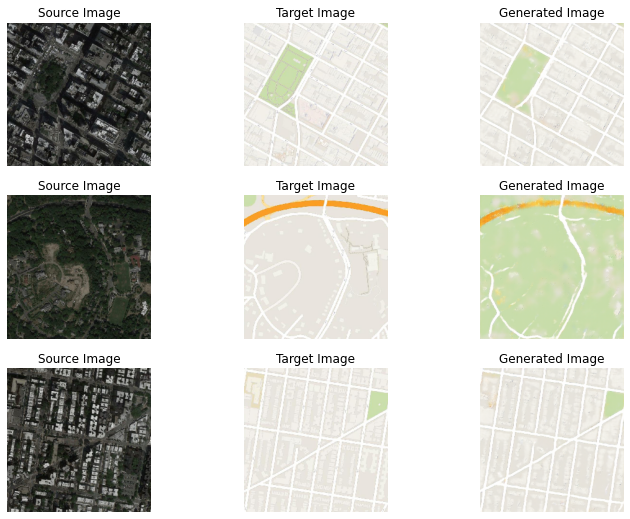

In [ ]:
train(d_model, g_model, gan_model, train_dataset)